# Chapter 3: Your First GAN

In [1]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

## Generator

In [3]:
def build_generator(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28*28*1, activation='tanh'))
    
    # Ensure the generate image has the same shape as the real images
    model.add(Reshape(img_shape))

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Build the Model

In [5]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # Stack Generator and Discriminator 
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(
                loss='binary_crossentropy', 
                optimizer=Adam(), 
                metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(
    loss='binary_crossentropy', 
    optimizer=Adam())

## Training

In [7]:
losses = []
accuracies = []


def train(iterations, batch_size, sample_interval):
    
    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = gan.train_on_batch(z, real)
        
        # Save losses and accuracies so they can be plotted after training
        losses.append((d_loss[0], g_loss))
        accuracies.append(100*d_loss[1])

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))

            # Output generated image samples 
            sample_images(iteration)

In [8]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise 
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

## Train the Model and Inspect Output

In [9]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

0 [D loss: 0.576378, acc.: 50.39%] [G loss: 0.598830]
1000 [D loss: 0.065351, acc.: 98.44%] [G loss: 5.059836]
2000 [D loss: 0.222689, acc.: 91.80%] [G loss: 5.700258]
3000 [D loss: 0.304125, acc.: 84.38%] [G loss: 5.155662]
4000 [D loss: 0.173413, acc.: 93.36%] [G loss: 4.634071]
5000 [D loss: 0.139471, acc.: 95.70%] [G loss: 4.044922]
6000 [D loss: 0.279703, acc.: 90.23%] [G loss: 4.525804]
7000 [D loss: 0.271768, acc.: 91.80%] [G loss: 4.618593]
8000 [D loss: 0.148145, acc.: 94.53%] [G loss: 3.563412]
9000 [D loss: 0.280569, acc.: 89.06%] [G loss: 4.161238]
10000 [D loss: 0.272877, acc.: 88.28%] [G loss: 4.146420]
11000 [D loss: 0.433806, acc.: 83.20%] [G loss: 3.513283]
12000 [D loss: 0.293925, acc.: 86.33%] [G loss: 3.683616]
13000 [D loss: 0.236096, acc.: 89.06%] [G loss: 3.446990]
14000 [D loss: 0.452274, acc.: 79.30%] [G loss: 3.544476]
15000 [D loss: 0.332379, acc.: 88.67%] [G loss: 3.673915]
16000 [D loss: 0.582919, acc.: 76.95%] [G loss: 2.488882]
17000 [D loss: 0.397328, ac

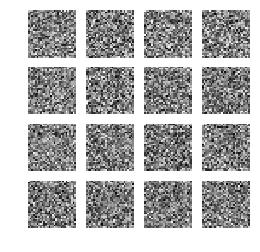

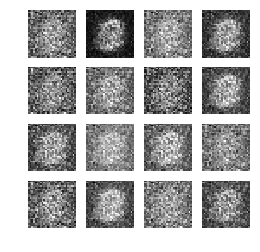

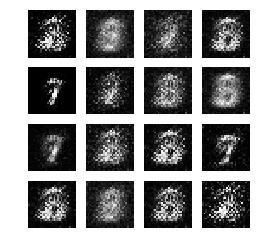

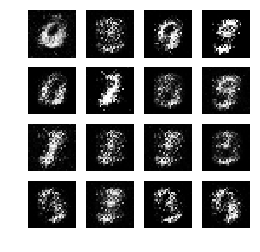

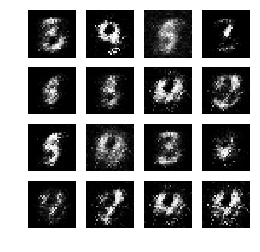

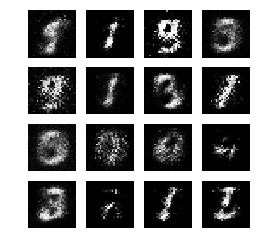

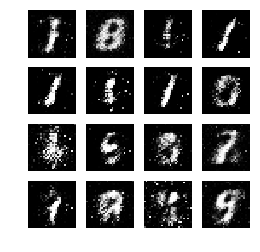

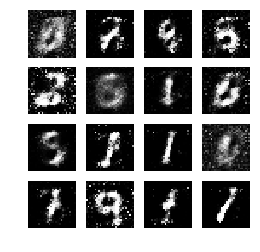

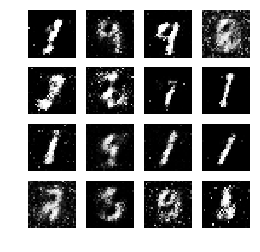

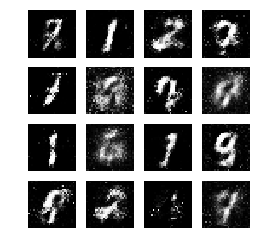

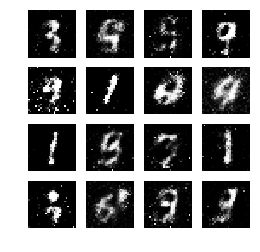

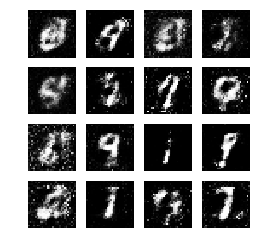

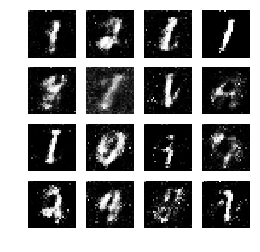

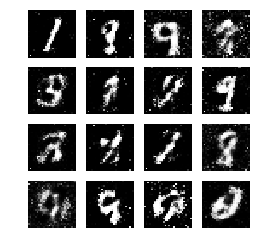

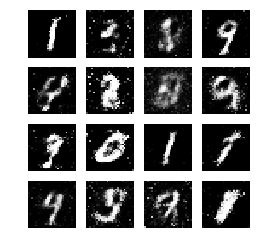

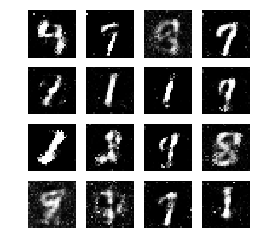

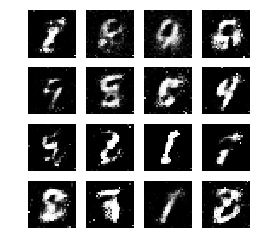

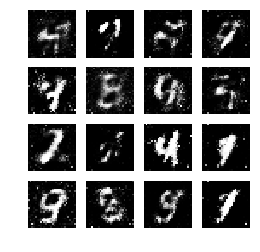

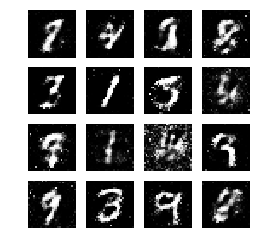

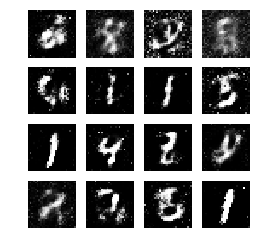

In [10]:
iterations = 20000
batch_size = 128
sample_interval = 1000


# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

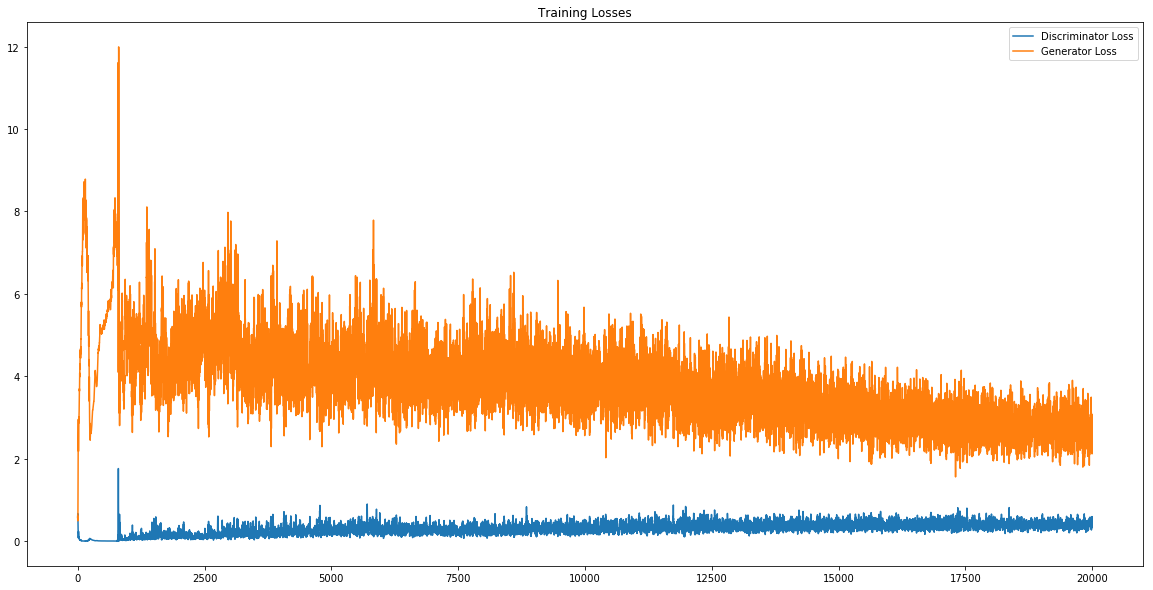

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(20, 10))
plt.plot(losses.T[0], label="Discriminator Loss")
plt.plot(losses.T[1], label="Generator Loss")
plt.title("Training Losses")
plt.legend()

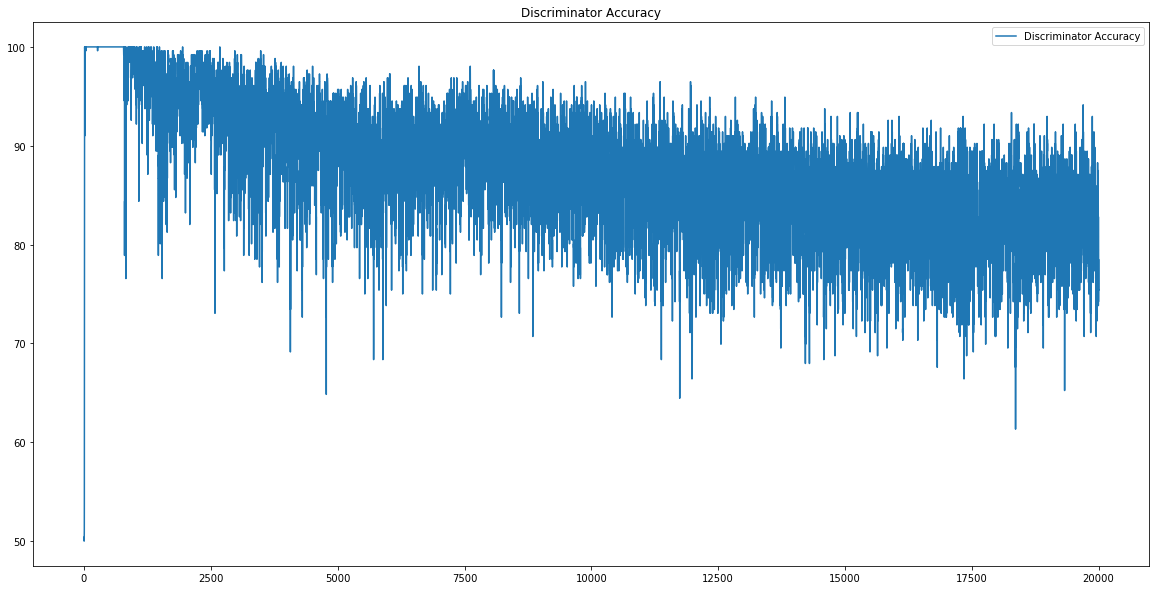

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(20, 10))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()